# Generate dataset

Here we generate white 128x128 pictures with drawn rectangles. Width of each rectangle border varies between 1pix and 5pix as well as number of rectangles per image (1 to 5). 

Also, all pictures randomly rotated between -10 and 10 degrees.


In [1]:
import cv2
import random
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

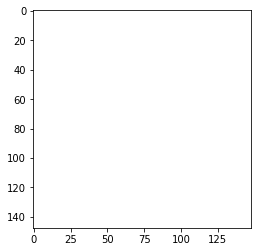

In [2]:
# example plain white
width = 128 + 20
height = 128 + 20

img = np.zeros([width, height, 3], dtype=np.uint8)
img.fill(255)

cv2.imwrite('test.jpg', img)

plt.imshow(img)  
plt.show()

## Helper functions

In [3]:
# draw black rectangle
def random_rectangle(img):
    # initial image bigger than 128x128. we need 128x128
    shape = (128, 128)
    diff = img.shape[0] - shape[0]
    
    # set number of rectangles
    num_of_rect = int(random.uniform(1, 5))
    
    for i in range(num_of_rect):
        # set (x, y) for rectangle's center point
        rect_center_x = int(random.uniform(diff//2, img.shape[1]-diff//2))
        rect_center_y = int(random.uniform(diff//2, img.shape[0]-diff//2))

        # set width and height for rectangle
        rect_w = int(random.uniform(0.1*shape[1], shape[1]))
        rect_h = int(random.uniform(0.1*shape[0], shape[0]))

        # calculate points for drawing
        left_top_x = rect_center_x - rect_w // 2 
        left_top_y = rect_center_y - rect_h // 2
        right_bottom_x = rect_center_x + rect_w // 2
        right_bottom_y = rect_center_y + rect_h // 2

        # set width of the border between 1pix and 5 pix
        border = int(random.uniform(1, 5))
        
        # draw rectangle
        cv2.rectangle(img, (left_top_x, left_top_y), (right_bottom_x, right_bottom_y), (0,0,0), border)
    
    return img

# rotate image between -angle, angle
def random_rotation(img):
    # set range
    angles = 11
    angle = round(random.uniform(-angles, angles), 2)
    
    # rotate
    height, width, ch = img.shape
    shape = (width, height)
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img = cv2.warpAffine(img, M, shape)
    
    # crop 128x128 from center in order to get rid of black borders after rotation
    new_width = 128
    new_height = 128
    img = img[(center[1]-new_height//2):(center[1]+new_height//2), 
              (center[0]-new_width//2):(center[0]+new_width//2)]
    
    return img, angle

## Example of one generated image

Shape of initial image:  (148, 148, 3)
Shape of rotated image:  (128, 128, 3)
Angle of rotation:  -10.4 degrees


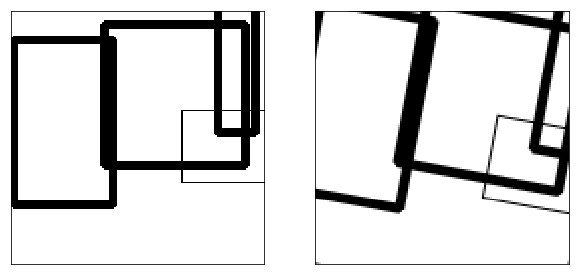

In [4]:
# example
random.seed(2)
img = mpimg.imread('test.jpg')
im = []
im.append(random_rectangle(img))
print("Shape of initial image: ", im[0].shape)
im_1, a = random_rotation(img)
im.append(im_1)
print("Shape of rotated image: ", im[1].shape)
print("Angle of rotation: ", a, "degrees")

n_rows = 1
n_cols = 2
plt.figure(figsize=(10, 5))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    test = im[i]
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(test)

## Generate dataset of 11000 training pictures

In [5]:
# create one samle image
def create_sample(index, data, category):
    # set WxH of initial image
    width = 128 + 20
    height = 128 + 20
    
    # create plain white image
    img = np.zeros([width, height, 3], dtype=np.uint8)
    img.fill(255)
        
    # draw rectangles
    img = random_rectangle(img)

    # randomly rotate image
    img, angle = random_rotation(img)

    # save image
    cv2.imwrite('./{}/sample{}.jpg'.format(category, index), img)
    
    # calculate sin/cos
    sin = np.sin(angle * np.pi / 180)
    cos = np.cos(angle * np.pi / 180)
    
    # save data for csv log
    data['image'].append('./{}/sample{}.jpg'.format(category, index))
    data['angle'].append(angle)
    data['cos'].append(cos)
    data['sin'].append(sin)

In [6]:
# set number of samples to create
# 11000 training set 1000 test set 
num_of_samples_train = 100
num_of_samples_test = 10

In [7]:
# generate samples

# empty data dict for csv log
data_train = {'image':[], 'angle':[], 'cos':[], 'sin':[]}
data_test =  {'image':[], 'angle':[], 'cos':[], 'sin':[]}

# Go!
# training set
for i in range(num_of_samples_train):
    create_sample(i, data_train, 'data_train')
    
# training set
for i in range(num_of_samples_test):
    create_sample(i, data_test, 'data_test')

## Save to csv file ['angle', 'path/to/image']

In [8]:
# create pandas DF
samples_data_train = pd.DataFrame(data_train)
samples_data_test = pd.DataFrame(data_test)

In [9]:
samples_data_train.to_csv('datalog_train.csv', index=False)
samples_data_test.to_csv('datalog_test.csv', index=False)

In [10]:
# read csv logs and check if everything ok
rows = pd.read_csv('datalog_train.csv')
rows.describe()

,angle,cos,sin
count,100.000000,100.000000,100.000000
mean,-0.848800,0.992776,-0.014759
std,6.875709,0.005475,0.119550
min,-10.740000,0.981727,-0.186353
25%,-6.935000,0.988461,-0.120743
50%,-1.935000,0.993483,-0.033766
75%,6.262500,0.997684,0.109084
max,10.970000,1.000000,0.190295


## Check

Number of samples:    100
Shape of the images:  (128, 128, 3)


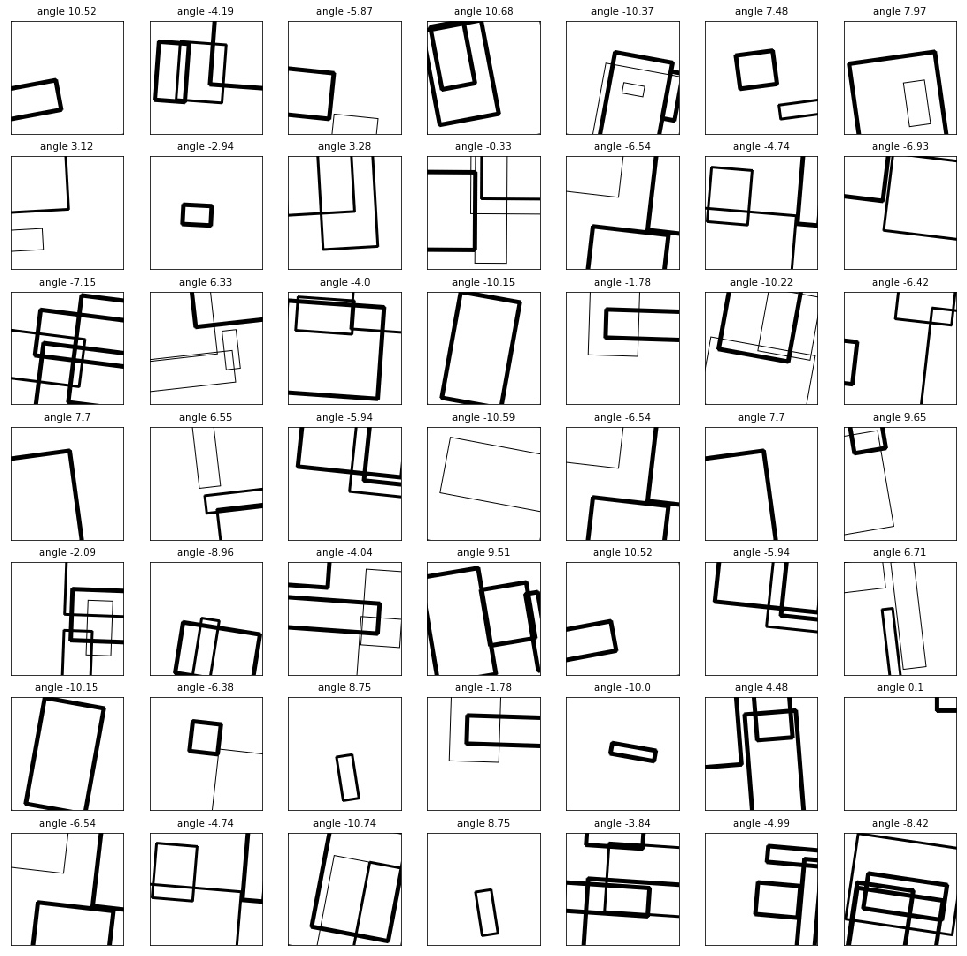

In [11]:
# load samples
images = rows['image'].tolist()
angles = rows['angle'].tolist()

samples = []
for img in images:
    image = mpimg.imread(img)
    samples.append(image)
    
print("Number of samples:   ", len(samples))
print("Shape of the images: ", samples[0].shape)

n_rows = 7
n_cols = 7
plt.figure(figsize=(17, 17))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(samples)-1)
    image = samples[index]
    plt.title('angle ' + str(angles[index]), fontsize=10)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)